# Import Libraries

In [1]:
import os, time, math
from datetime import datetime

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, SGDRegressor, Perceptron
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.neural_network import MLPRegressor

# Import Data

In [2]:
# Creating the df from excel file
file = 'OSA_propio.csv'
df = pd.read_csv(file)
df.set_index("Patient", inplace=True)
df = pd.get_dummies(df, drop_first=False, columns=["Gender","Smoker","Snorer","Illness"])
df

,Age,IAH,Cervical,Weight,Height,BMI,Gender_hombre,Gender_mujer,Smoker_antiguo,Smoker_no,Smoker_ns,Smoker_si,Snorer_CPAP,Snorer_no,Snorer_ns,Snorer_si,Illness_no,Illness_ns,Illness_si
Patient,,,,,,,,,,,,,,,,,,,
P0002,56.0,29.6,48.0,119.0,174.0,39.31,1,0,0,0,0,1,0,0,1,0,0,1,0
P0004,39.0,19.7,42.0,78.0,168.0,27.64,1,0,0,1,0,0,0,0,1,0,0,0,1
P0005,32.0,9.0,40.0,80.0,173.0,26.73,1,0,0,1,0,0,0,0,1,0,0,0,1
P0006,32.0,2.0,42.0,109.0,190.0,30.19,1,0,0,1,0,0,0,0,1,0,0,0,1
P0007,39.0,34.0,42.0,86.0,169.0,30.11,1,0,0,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P0677,64.0,36.3,39.0,82.0,165.0,30.12,0,1,1,0,0,0,0,0,0,1,0,0,1
P0679,35.0,9.2,45.0,105.0,180.0,32.41,1,0,0,1,0,0,0,0,0,1,0,0,1
P0680,50.0,52.2,42.0,90.0,180.0,27.78,1,0,0,1,0,0,0,0,0,1,1,0,0


# Functions

In [13]:
def inverse_transform(data):
    if log_transform_on:
        return 10**data-1
    elif minmax_sc_on or standard_sc_on:
        return sc_y.inverse_transform(data)
    else:
        return data



def insert_result(model,description,mae,rmse,r2,interval,date):
    line = ""
    string_features = ""
    for ele in x_features:
        string_features = string_features + "-" + ele
    for column in [model, description,
                   mae, rmse, r2,
                   cv_on,
                   string_features[1:], len(x_features), len(x_features)>1,
                   poly_on, poly_deg,
                   log_transform_on,
                   minmax_sc_on, standard_sc_on,
                   pca_on, pca_per,
                   interval, date]:
        line = line + "," + str(column)
    os.system("echo " + line[1:] + " >> regression_results.csv")


    
def fit_model(model, X, y):

    start = time.time()
    y_pred = cross_val_predict(model,X,y,cv=cv_on)
    end = time.time()
    
    y = inverse_transform(y)
    y_pred = np.reshape(y_pred, (len(y_pred), 1))
    y_pred = inverse_transform(y_pred)

    mae = round(mean_absolute_error(y, y_pred),2)
    rmsd = round(math.sqrt(mean_squared_error(y, y_pred)),2)
    r2 = round(r2_score(y, y_pred)*100,2)
    t = round(end-start,4)
    error = [y_pred[i,0] - y[i,0] for i in range(len(y_pred))]
    
    return y, y_pred, mae, rmsd, r2, t, error



def plot_model(y, y_pred, error, model_name, description, date):
    
    name_fig = model_name + "_" + description + "_" +  date
    
    plt.title('Prediction Scatter'), plt.xlabel('Real IAH'), plt.ylabel('Predicted IAH')
    plt.scatter(y, y_pred)
    plt.plot([y.min(), y.max()], [y_pred.min(), y_pred.max()], 'k--', lw=3)
    if save_model:
        plt.savefig("scatter_"+name_fig)
    plt.show()

    plt.title('Error Histogram'), plt.xlabel('Error'), plt.ylabel('Total Number of Errors')
    plt.hist(error, bins=10)
    if save_model:
        plt.savefig("hist_"+name_fig)
    plt.show()
    
    abs_error = [abs(x) for x in error]
    plt.ylabel('Absolute Error')
    plt.title('Error Boxplot')
    plt.boxplot(abs_error)
    if save_model:
        plt.savefig("box_"+name_fig)
    plt.show()
    
    if model in ["extra_tree_reg","tree_reg"]:
        tree_reg = reg_models[model].fit(X,y)
        plt.figure(figsize=(10,10))
        plot_tree(tree_reg, filled=True, rounded=True)
        if save_model:
            plt.savefig("tree_"+name_fig)

# Global Parameters

In [14]:
#Data Splitting
test_per = 0.2
random_st = 34

#Feature Selection. Future versions: Aggregation and Selection technique
x_features = ["Age","Cervical","Weight","Height", "BMI","Gender_hombre"] 
y_features = ["IAH"]
#["Age","Cervical","Weight","Height", "BMI","Gender_hombre"]
#list(df)
#x_features.remove("IAH")

#Data Transformations. Future versions: Square root, natural and max sc
poly_on, poly_deg = False, 2
log_transform_on = False
minmax_sc_on = True
standard_sc_on = False

#Dimensionality reduction. Future versions: Manifold
pca_on = False
pca_per = 0.8

#Cross Validation. Future versions: GridSearch, RandomSearch
cv_on = 10 #1 for no cv

# Data Transformation

In [15]:
X = df[x_features] 
y = np.reshape(df[y_features].values, (len(df[y_features]), 1))

if len(x_features)==1:
    X = np.reshape(df[x_features].values, (len(df[x_features]), 1))    
    
if poly_on:
    poly_features = PolynomialFeatures(degree=poly_deg, include_bias=False)
    X = poly_features.fit_transform(X)
    
if log_transform_on:
    if len(x_features)==1:
        X = np.log10(X + 1)
    else:
        X[X.select_dtypes(include='float64').columns] = np.log10(X[X.select_dtypes(include='float64').columns] + 1)
    y = np.log10(y + 1)
    
if minmax_sc_on:
    sc_x, sc_y = MinMaxScaler(), MinMaxScaler()
    X = sc_x.fit_transform(X)
    y = sc_y.fit_transform(y)
    
if standard_sc_on:
    sc_x, sc_y = StandardScaler(), StandardScaler()
    X = sc_x.fit_transform(X)
    y = sc_y.fit_transform(y)
    
if pca_on:
    pca = PCA(pca_per) 
    X = pca.fit_transform(X)
    print('Number of components: ' + str(pca.n_components_))
    print('Value of components: ' + str(pca.components_))

# Model Dictionary

In [16]:
reg_models={
    #Classical models -> least square model, SGD
    "linear_reg": LinearRegression(),
    "sgd_reg": SGDRegressor(loss='huber', #SCALE WITH MINMAX
                            penalty='l2'),
    #Regularizers: Laso, Ridge, ElasticNet
    "Lasso_reg": Lasso(alpha=0.1),
    "Ridge_reg": Ridge(alpha=1,
                       solver="cholesky"),
    "ElasticNet_reg": ElasticNet(alpha=0.1,
                                 l1_ratio=0.5),
    #kNN models
    "knn_reg": KNeighborsRegressor(n_neighbors=15),
    "radius_neigh_reg": RadiusNeighborsRegressor(radius=100.0),
    #Tree-based models
    "tree_reg": DecisionTreeRegressor(criterion='mse',
                                      splitter='mse',
                                      max_depth=None,
                                      min_samples_split=150,
                                      min_samples_leaf=150,
                                      max_leaf_nodes=None,
                                      random_state=random_st),
    "extra_tree_reg": ExtraTreeRegressor(criterion='mse',
                                      splitter='random',
                                      max_depth=None,
                                      min_samples_split=150,
                                      min_samples_leaf=150,
                                      max_leaf_nodes=None,
                                      random_state=random_st),
    #Ensemble models
    "bagging_reg": BaggingRegressor(base_estimator=Lasso(),
                                    n_estimators=300,
                                    max_samples=100,
                                    n_jobs=-1),
    "randomforest_reg": RandomForestRegressor(n_estimators=800,
                                              max_leaf_nodes=16,
                                              n_jobs=-1),
    "adaboost_reg": AdaBoostRegressor(DecisionTreeRegressor(max_depth=1),
                                      n_estimators=300,
                                      loss="exponential",
                                      learning_rate=0.5),
    "gradientboost_reg": GradientBoostingRegressor(max_depth=2,
                                                   n_estimators=100), #early stooping for best numer of trees
    "xgboost_reg": XGBRegressor(max_depth=3,
                                learning_rate=0.5,
                                n_estimators=100,
                                n_jobs=-1),
    #Support Vector Machines. ENABLE STANDARD SCALER!!!
    "svr_linear_reg": LinearSVR(epsilon=1,
                                C=10),
    "svr_reg": SVR(kernel="poly",
                          degree=3,
                          C=10,
                          epsilon=0.5),
    #Neural Networks
    "mlp_reg": MLPRegressor(hidden_layer_sizes=(1, ),
                            activation='relu',
                            solver='sgd'),
}

# Model Fitting & Result

Model: sgd_reg lossEpsilonRegL2
MAE: 13.01 RMSE: 17.97 R2: 6.47 time: 0.0109


/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d arr

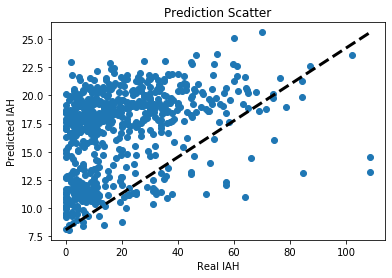

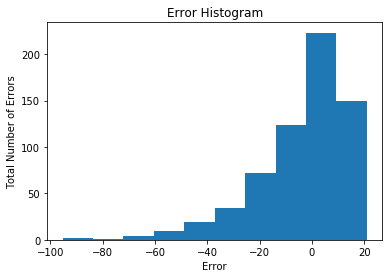

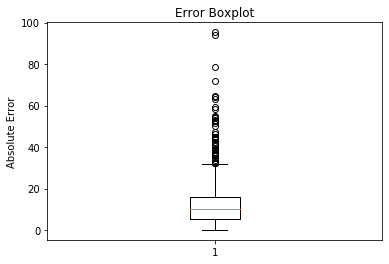

In [17]:
model = "sgd_reg"
description = "lossEpsilonRegL2"
save_model = False
date = datetime.today().strftime('%Y-%m-%d_%H:%M:%S')

y, y_pred, mae, rmse, r2, interval, error = fit_model(reg_models[model], X, y)

print("Model:",model,description)
print("MAE:",str(mae),"RMSE:",str(rmse),"R2:",str(r2),"time:",str(interval))

plot_model(y, y_pred, error, model, description, date)

if save_model:
    insert_result(model,description,mae,rmse,r2,interval,date)